In [2]:
import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests


# Spivakov ILC3 and CD4+ T cell Analysis Rerun

This notebook will walk through the analysis of pcHi-C data generated by Mikhail Spivakov's group. We will also analyze CD4+ alpha-beta T-cells in addition to the ILC3 data as a positive control sample.

There are two parts to this analysis. The sections are as follows:

## Data Overview

We have two cell types to analyze:

* Human Tonsil ILC3
* Human Venous Blood CD4+ alpha/beta T-cells

These two cell types were analyzed with two different analysis methods:

* 5kb bin level - interactions are approximately 5k bins instead of the size of restriction fragments
* fragment level - interactions are the size of the restriction fragment made by DPNII
  
For the following analysis we remove transchromosomal interactions and off-target interactions.

## Preliminary set up

## Analysis of RELI results

In [3]:
results_dir = "/Users/caz3so/workspaces/tacazares/pchic/data/RELI/results"

In [4]:
def import_reli_results(file):
    disease = os.path.basename(file).replace(".txt", "").replace("_", " ")
    
    header = ["input", "Track", "Cell", "TF", "Overlap", "Total", "Ratio", "Mean", "STD", "Z-score", "Enrichment", "P-val", "Corrected P-val"," Null_Model", "Species"]
    
    df = pd.read_table(file, names=header)
    
    df["disease"] = disease
    
    return df

In [5]:
results_list = []

for results in glob.glob(os.path.join(results_dir, "*.txt")):

    results_list.append(import_reli_results(results))
    
results_df = pd.concat(results_list)

#results_df.to_csv("20220509_spivakov_ILC3_CD4_RELI_results_all.txt", sep="\t", index=False)

In [6]:
def RELI_results(results_df, samples: list, output_filename, fdr_cutoff = .05):
    """Process RELI results

    Args:
        results_df (_type_): Dataframe of results from collecting and concatenating RELI outputs
        samples (list): Sample names found in the cell column. Each df will be split by sample name and pvalue corrected.
        output_filename (_type_): The output filename that is to be used for the final data table
        fdr_cutoffs (list, optional): FDR cutoffs to use for analysis. Two columns will be added for each cutoff.

    Returns:
        _type_: _description_
    """
    df = results_df[results_df["Cell"].isin(samples)].copy()
    
    sample_list = []
    
    for sample in samples:
        # Subset the dataframe to the specific experiment
        sample_df = df[df["Cell"] == sample].copy()
        
        # Run the Benjamini-Hochberg Procedure https://stats.stackexchange.com/questions/238458/whats-the-formula-for-the-benjamini-hochberg-adjusted-p-value
        bh_pvals = multipletests(pvals=sample_df["P-val"], alpha=0.05, method="fdr_bh")
            
        # Create a column that has the BH results: Boolean for true or false for enrichment
        sample_df["BH_FDR5per"] = bh_pvals[0]

        # Create a column that has the adjusted pvalues for the BH procedure
        sample_df["BH_corrected_pval"] = bh_pvals[1]

        # Run the Bonferroni correction method
        bon_pvals = multipletests(pvals=sample_df["P-val"], alpha=0.05, method="bonferroni")
        
        # Set a column for the bonferonni corrected pvalues
        sample_df["Bon_corrected_pval"] = bon_pvals[1]
        
        # -log10(raw pval)
        sample_df["neg_log_ten"] = -np.log10(sample_df["P-val"])

        # -log10(raw pval)
        sample_df["BH_neg_log_ten"] = -np.log10(sample_df["BH_corrected_pval"])
        
        # -log10(raw pval)
        sample_df["Bon_neg_log_ten"] = -np.log10(sample_df["Bon_corrected_pval"])

        sample_list.append(sample_df)
    
    df = pd.concat(sample_list)

    df.drop(["input", "Track", "TF", "Corrected P-val", "Species"], axis=1, inplace=True)
    
    df.to_csv(output_filename, sep="\t", index=False)
        
    return df

In [7]:
RELI_results_df = RELI_results(results_df, 
             ["CD4_1M_50K_5kb_within_newbmap_CHiCAGO_ABC_peakm_PIR_intersect_RE", 
              "ILC3_merged_bin5K_score5_PIR_intersect_RE",
              "CD4_1M_50K_5kb_within_newbmap_CHiCAGO_peakm_PIR_intersect_RE",
              "ILC_5kb_within_newbmap_CHiCAGO_ABC_peakm_PIR_intersect_RE",
              "CD4_1M_50K_merged_reweighting_peakmatrix_score5_PIR_intersect_RE"],
             "/Users/caz3so/workspaces/tacazares/pchic/data/RELI/20220625_spivakov_ILC3_CD4_50K_RELI_ABC_results.tsv")

In [8]:
cd4_1M = RELI_results(results_df, 
             ["hILC3_10K_dpnII_5kbin_PIR_overlapRE_intersection", "CD4_1M_dpnII_5kbin_PIR_overlapRE_intersection"],
             "/Users/caz3so/scratch/20220428_RELI_spivakov_rerun/output/RELI/RELI_final/20220517_spivakov_ILC3_CD4_1M_RELI_results.tsv")

In [8]:
table_1M_bh = pd.pivot_table(data=RELI_results_df, index="disease", columns="Cell", values="BH_neg_log_ten")
table_1M_bh.reset_index(inplace=True)

#table_50k_bh = pd.pivot_table(data=cd4_50k, index="disease", columns="Cell", values="BH_neg_log_ten")
#table_50k_bh.reset_index(inplace=True)

#table_1M_bon = pd.pivot_table(data=cd4_1M, index="disease", columns="Cell", values="Bon_neg_log_ten")
#table_1M_bon.reset_index(inplace=True)

#table_50k_bon = pd.pivot_table(data=cd4_50k, index="disease", columns="Cell", values="P-val")
#table_50k_bon.reset_index(inplace=True)

In [20]:
table_1M_bh.to_csv("/Users/caz3so/workspaces/tacazares/pchic/data/RELI/20220625_RELI_763phenotypes_5samples.tsv", sep="\t", index=False)

In [23]:
table_1M_bh[''] table_1M_bh.max()

In [33]:
table_1M_bh = table_1M_bh.set_index("disease")

In [45]:
table_1M_bh[table_1M_bh.max(axis=1) > 1.3].to_csv("/Users/caz3so/workspaces/tacazares/pchic/data/RELI/20220625_RELI_98phenotypes_5samples.tsv", sep="\t")

In [21]:
-np.log10(.05)

1.3010299956639813

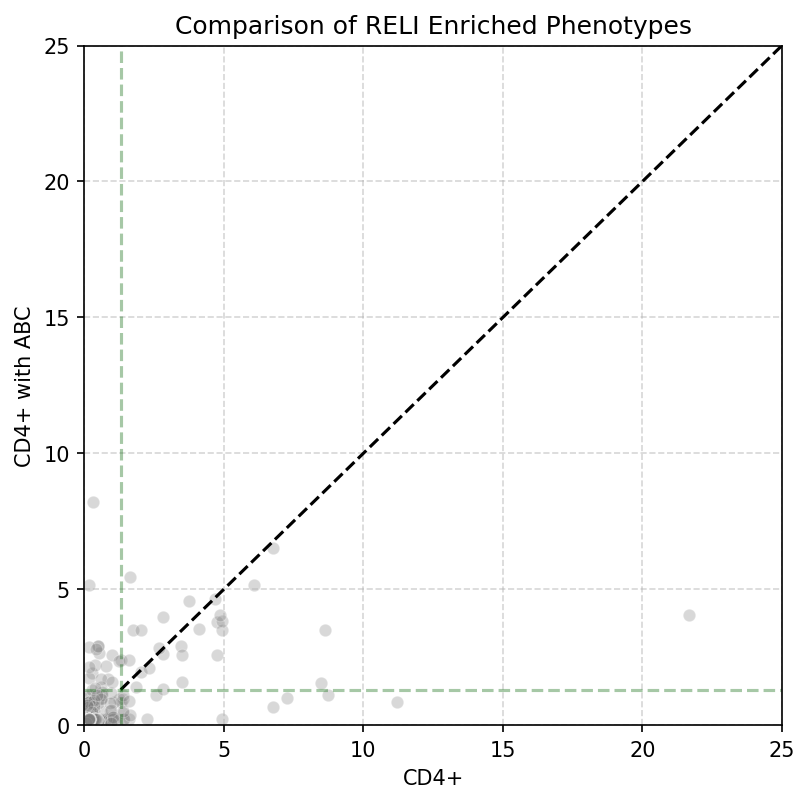

In [18]:
plt.figure(figsize=(6,6), dpi=150)

sns.scatterplot(data=table_1M_bh, 
                x="CD4_1M_50K_5kb_within_newbmap_CHiCAGO_peakm_PIR_intersect_RE", 
                y = "ILC3_merged_bin5K_score5_PIR_intersect_RE",
                color="grey",
                alpha=.3
                )

plt.xlim(0,25)
plt.ylim(0,25)

plt.plot([-np.log10(.05),30], [-np.log10(.05),30], color="k", ls='--')

plt.grid(which="both", alpha=.5, ls="--")
plt.title("Comparison of RELI Enriched Phenotypes")

plt.ylabel("CD4+ with ABC")
plt.xlabel("CD4+")

plt.vlines(x=-np.log10(.05), ymin=0,ymax=30, color="darkgreen", linestyle="--", alpha=.35)
plt.hlines(y=-np.log10(.05), xmin=0,xmax=30, color="darkgreen", linestyle="--", alpha=.35)


In [27]:
plt.figure(figsize=(6,6), dpi=150)

sns.scatterplot(data=table_1M_bh, 
                x="CD4_1M_dpnII_5kbin_PIR_overlapRE_intersection", 
                y = "hILC3_10K_dpnII_5kbin_PIR_overlapRE_intersection",
                color="grey",
                alpha=.3
                )

ILC_above = table_1M_bh[table_1M_bh["hILC3_10K_dpnII_5kbin_PIR_overlapRE_intersection"] > -np.log10(.05)]

CD4_above = table_1M_bh[table_1M_bh["CD4_1M_dpnII_5kbin_PIR_overlapRE_intersection"] > -np.log10(.05)]

sns.scatterplot(data=ILC_above, 
                x="CD4_1M_dpnII_5kbin_PIR_overlapRE_intersection", 
                y = "hILC3_10K_dpnII_5kbin_PIR_overlapRE_intersection",
                color="#c51b7d"
                )

sns.scatterplot(data=CD4_above, 
                x="CD4_1M_dpnII_5kbin_PIR_overlapRE_intersection", 
                y = "hILC3_10K_dpnII_5kbin_PIR_overlapRE_intersection",
                color="#c51b7d"
                )

plt.xlim(0,)
plt.ylim(0,)

plt.plot([-np.log10(.05),20], [-np.log10(.05),20], color="k", ls='--')

plt.grid(which="both", alpha=.5, ls="--")
plt.title("Comparison of RELI Enriched Phenotypes")

plt.vlines(x=-np.log10(.05), ymin=0,ymax=20, color="darkgreen", linestyle="--", alpha=.35)
plt.hlines(y=-np.log10(.05), xmin=0,xmax=20, color="darkgreen", linestyle="--", alpha=.35)

plt.xlabel("CD4+ 1M dpnII PIR overlap RE -log$_{10}$(BH Corrected p-value)")
plt.ylabel("ILC3 dpnII PIR overlap RE -log$_{10}$(BH Corrected p-value)")

plt.savefig("/Users/caz3so/scratch/20220428_RELI_spivakov_rerun/output/RELI/RELI_final/RELI_ILC3_CD4_BH_fdr5percent_pvalue_neglog10.png")

ValueError: Could not interpret value `CD4_1M_dpnII_5kbin_PIR_overlapRE_intersection` for parameter `x`

<Figure size 900x900 with 0 Axes>